# DEF CON 27 AI Village
## Fighting Malware with Deep Learning
## Convolutional Neural Networks and Static Analysis Data (Raw Binary)
### Angelo Oliveira @ang3loliveira
#### Datasets available at:
https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-pe-static-images

In [1]:
import numpy as np
np.random.seed(137)

import time
from collections import Counter
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Each goodware/malware was treated as an image: Scaled to 32x32x1 (grayscale)
df_1 = pd.read_csv('static_image_per_goodware.csv')
df_1.head()

,hash,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,c7e50189473e530f304b43a12a56e2bd,0,21,0,0,0,18,0,0,0,...,221,121,190,4,13,35,36,49,228,0
1,ba04584917d498daf6b054f1476e93e1,199,15,104,0,0,80,255,251,69,...,48,49,49,64,180,57,58,12,204,0
2,de6fb739ae97e914affa2b857aa04e48,2,115,115,132,0,0,0,10,125,...,121,0,101,115,0,101,0,0,0,0
3,2b53a92f4bb168b893c4722f56c2201e,145,255,255,255,123,255,106,255,108,...,0,0,0,0,0,0,0,0,0,0
4,75f8cc892f8c14b2ffa646c2e58e14e6,46,8,255,137,240,117,120,83,116,...,5,175,180,130,130,7,13,175,159,0


In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 20.2+ MB


In [4]:
df_2 = pd.read_csv('static_image_per_malware.csv')
df_2.head()

,hash,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,b324140e1fb35dc6b694879ba1f2be45,15,15,239,15,223,36,102,243,102,...,31,242,245,169,212,17,255,160,122,1
1,1d32b1326a524b163eb74af645cd34d5,234,196,8,20,182,56,27,223,144,...,189,228,156,54,189,82,177,125,193,1
2,e44fea4913fc9fd91b8b07c4670aeac4,196,255,5,97,35,112,219,189,217,...,254,189,227,255,192,231,253,196,233,1
3,95badb16d862ba94ae85c44e4b31d749,232,252,183,39,51,1,255,87,94,...,210,52,55,95,230,48,53,103,65,1
4,f30f32a4f42678ef49a543356d580232,81,84,204,228,255,157,76,254,128,...,24,69,64,53,52,216,200,55,58,1


In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49376 entries, 0 to 49375
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 386.5+ MB


In [6]:
df_1.drop(['hash'], axis = 1, inplace = True)
df_2.drop(['hash'], axis = 1, inplace = True)
df = pd.concat([df_1, df_2])
del df_1, df_2
df.head()

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,0,21,0,0,0,18,0,0,0,83,...,221,121,190,4,13,35,36,49,228,0
1,199,15,104,0,0,80,255,251,69,102,...,48,49,49,64,180,57,58,12,204,0
2,2,115,115,132,0,0,0,10,125,169,...,121,0,101,115,0,101,0,0,0,0
3,145,255,255,255,123,255,106,255,108,255,...,0,0,0,0,0,0,0,0,0,0
4,46,8,255,137,240,117,120,83,116,131,...,5,175,180,130,130,7,13,175,159,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51959 entries, 0 to 49375
Columns: 1025 entries, pix_0 to malware
dtypes: int64(1025)
memory usage: 406.7 MB


In [9]:
X = df.values[:, 0:1024].astype('float')
y = df.values[:, 1024].astype('int')
print(X.shape)
print(y.shape)

(51959, 1024)
(51959,)


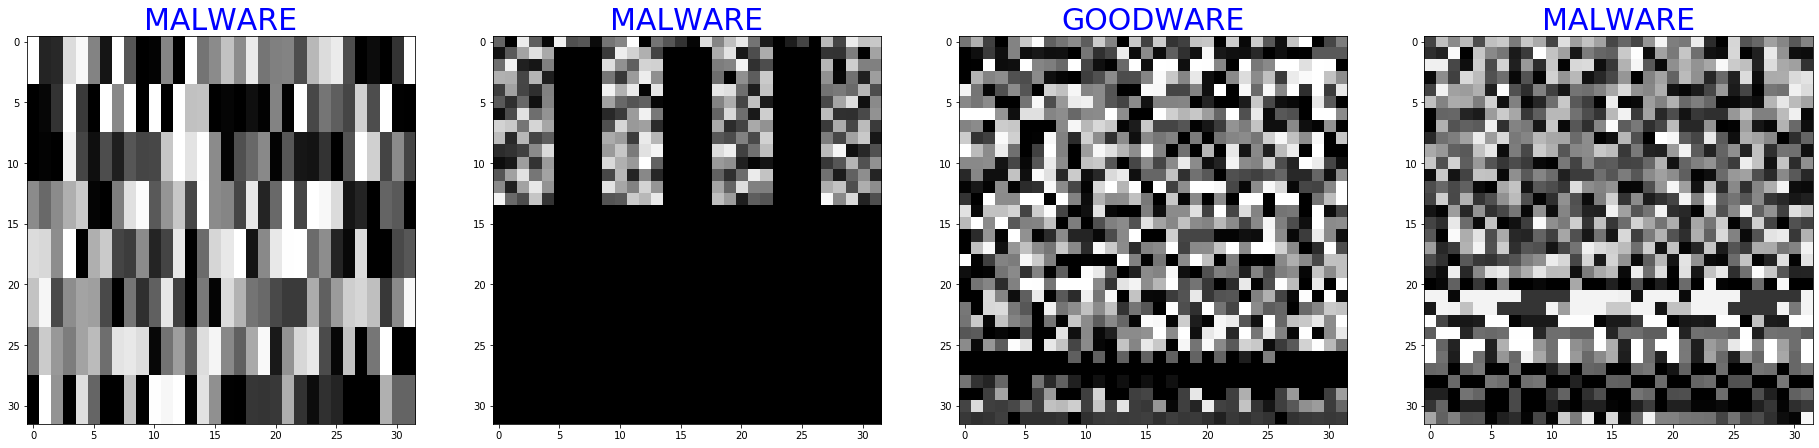

In [56]:
plt.figure(figsize = (32, 32))

examples = np.random.randint(0, X.shape[0], 4)

labels = []

for i in examples:
    if y[i] == 0:
        labels.append('GOODWARE')
    else:
        labels.append('MALWARE')

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.setp(plt.title(labels[i]), color = 'b', fontsize = 30)
    plt.imshow(
        X[np.random.randint(0, X.shape[0])].reshape(32, 32),
        cmap = 'gray',
        vmin = 0,
        vmax = 255)

In [57]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [58]:
check_imbalance(y)

[(0, 2583), (1, 49376)]
19.115756871854433


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

del X
del y

In [60]:
check_imbalance(y_train)
check_imbalance(y_test)

[(0, 1788), (1, 34583)]
19.3417225950783
[(0, 795), (1, 14793)]
18.60754716981132


In [61]:
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)

In [62]:
pd.DataFrame(X_train_std).head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1.000000,0.749020,0.341176,0.376471,0.901961,0.572549,0.592157,0.380392,0.172549,0.976471,...,0.560784,0.164706,0.694118,0.066667,0.007843,0.807843,0.000000,0.866667,0.466667,0.133333
1,1.000000,0.000000,0.101961,0.000000,0.262745,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.145098,1.000000,0.298039,0.000000,0.262745,1.000000,0.203922,1.000000,0.282353,1.000000
2,0.956863,0.933333,0.705882,0.333333,0.941176,0.913725,0.800000,0.458824,0.168627,0.078431,...,0.082353,0.070588,0.074510,0.074510,0.070588,0.082353,0.070588,0.074510,0.074510,0.070588
3,0.000000,0.000000,0.000000,0.615686,0.000000,0.447059,0.780392,1.000000,1.000000,0.686275,...,0.784314,0.223529,0.345098,0.235294,0.250980,0.203922,0.062745,0.062745,0.203922,0.345098
4,0.725490,0.458824,0.631373,0.270588,0.552941,0.490196,0.070588,0.584314,0.800000,0.956863,...,0.925490,0.847059,0.886275,0.000000,0.000000,0.203922,0.000000,0.219608,0.247059,0.815686


In [63]:
# SMOTE doesn't deal with categorical features
# SMOTE-NC (Nominal and Continuous) taking too much time

oversampler = RandomOverSampler()

X_res, y_res = oversampler.fit_resample(X_train_std, y_train)

check_imbalance(y_res)

del X_train_std

[(0, 34583), (1, 34583)]
1.0


## Visualization

In [64]:
def visualize(X, y, points, n_features):
    points = np.arange(points)
    np.random.shuffle(points)
    color = ['red' if l == 1 else 'green' for l in y[points]]
    for i in range(n_features):
        for j in range(n_features):
            if j > i:
                plt.scatter(X[points, i], X[points, j], color = color)
                plt.pause(0.1)
    return

In [65]:
def tsne(X):
    return TSNE().fit_transform(X)

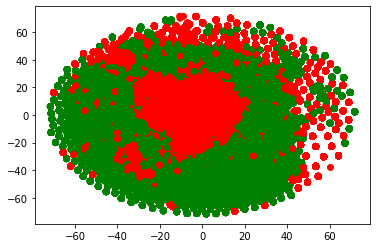

In [18]:
visualize(tsne(X_res), y_res, X_res.shape[0], 2)

del X_res
del y_res

## Enter Deep Learning

In [66]:
def select_model(model, model_arch):
    if model_arch == 1:
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(BatchNormalization())
    elif model_arch == 2:
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
    return

def create_model(model_arch = 1, neurons = 128, dropout_rate = 0.1, batch_drop = False):
    model = Sequential()
    model.add(Conv2D(32,
                     kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = (32, 32, 1),
                     padding = 'same'))
    select_model(model, model_arch)
    model.add(Conv2D(64,
                     kernel_size = (3, 3),
                     activation = 'relu',
                     padding = 'same'))
    select_model(model, model_arch)
    model.add(Flatten())
    model.add(Dense(neurons, activation = 'relu'))
    if batch_drop:
        model.add(BatchNormalization())
        model.add(Dropout(rate = dropout_rate))
    else:
        model.add(Dropout(rate = dropout_rate))
        model.add(BatchNormalization())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2

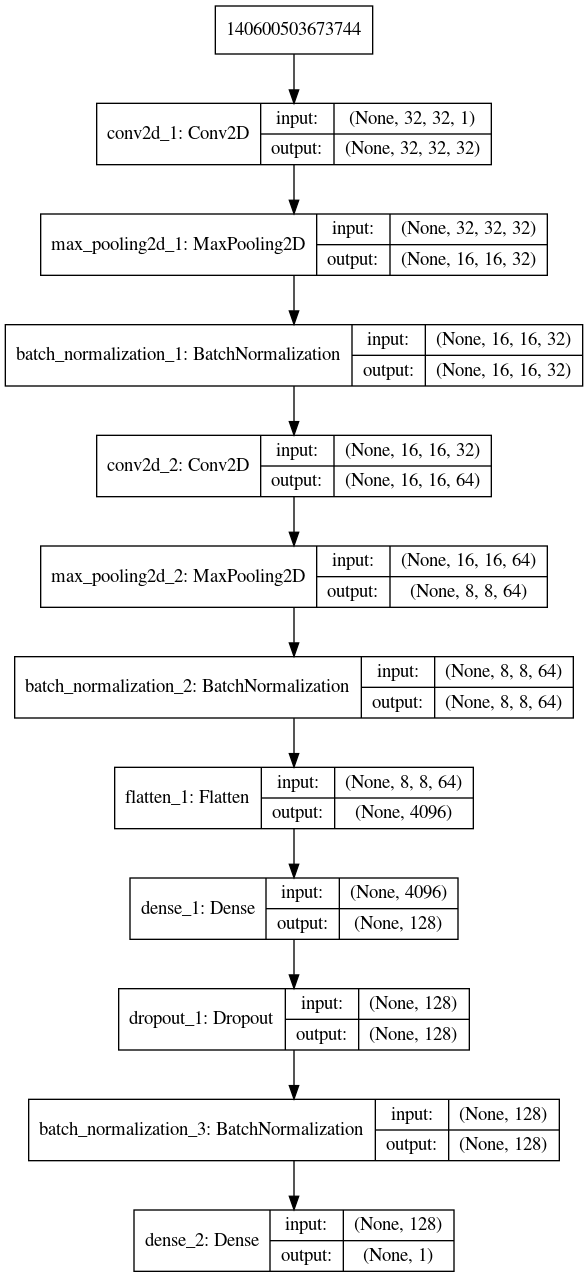

In [20]:
model = create_model()
model.summary()

plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)
del model
Image("model_plot.png")

## Model Selection

In [21]:
# Wrapper for Keras model to be used by the Pipeline
keras_classifier = KerasClassifier(
    build_fn = create_model,
    model_arch = 1,
    neurons = 128,
    dropout_rate = 0.1,
    batch_drop = False,
    batch_size = 64,
    epochs = 20,    
    verbose = 1
)

# Reshaping for CNN
def reshape_cnn(X):
    return X.reshape(-1, 32, 32, 1)

# Imbalanced Learn Pipeline
pipeline = Pipeline([
    ('sc', MinMaxScaler()),
    ('ros', RandomOverSampler()),
    ('rs', FunctionTransformer(reshape_cnn, validate = False)),
    ('kc', keras_classifier)
])

# Hyperparameters
model_arch = [1, 2]
neurons = [128, 256, 512]
dropout_rate = [0.1, 0.4, 0.6]
batch_drop = [False, True]

# Grid search using 3-fold cross-validation and score function Balanced Accuracy
# Balanced Accuracy = (TPR + TNR) / 2 = AUC (Binary Classification)
param_grid = dict(
    kc__model_arch = model_arch,
    kc__neurons = neurons,
    kc__dropout_rate = dropout_rate,
    kc__batch_drop = batch_drop
)

grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'balanced_accuracy',
    n_jobs = 1
)

In [22]:
t0 = time.time()
grid.fit(X_train, y_train)
print('Training / CV time: %is' % (time.time() - t0))

/home/angelo/anaconda3/envs/deeplearning_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
46062/46062 [==============================] - 5s 100us/step - loss: 0.1470 - acc: 0.9458
Epoch 2/20
46062/46062 [==============================] - 3s 59us/step - loss: 0.0203 - acc: 0.9961
Epoch 3/20
46062/46062 [==============================] - 3s 59us/step - loss: 0.0217 - acc: 0.9946
Epoch 4/20
46062/46062 [==============================] - 3s 60us/step - loss: 0.0119 - acc: 0.9973
Epoch 5/20
46062/46062 [==============================] - 3s 60us/step - loss: 0.0167 - acc: 0.9951
Epoch 6/20
46062/46062 [==============================] - 3s 64us/step - loss: 0.0119 - acc: 0.9965
Epoch 7/20
46062/46062 [==============================] - 3s 63us/step - loss: 0.0097 - acc: 0.9971
Epoch 8/20
46062/46062 [==============================] - 3s 66us/step - loss: 0.0074 - acc: 0.9983
Epoch 9/20
46062/46062 [==============================] - 3s 64us/step - loss: 0.0096 - acc: 0.9971
Epoch 10/20
46062/46062 [==========================

46084/46084 [==============================] - 3s 70us/step - loss: 0.0139 - acc: 0.9967
Epoch 17/20
46084/46084 [==============================] - 4s 76us/step - loss: 0.0031 - acc: 0.9992
Epoch 18/20
46084/46084 [==============================] - 3s 70us/step - loss: 0.0049 - acc: 0.9987
Epoch 19/20
46084/46084 [==============================] - 3s 70us/step - loss: 0.0101 - acc: 0.9969
Epoch 20/20
12124/12124 [==============================] - 1s 50us/step
Epoch 1/20
46154/46154 [==============================] - 4s 94us/step - loss: 0.1487 - acc: 0.9454
Epoch 2/20
46154/46154 [==============================] - 3s 67us/step - loss: 0.0170 - acc: 0.9965
Epoch 3/20
46154/46154 [==============================] - 3s 68us/step - loss: 0.0372 - acc: 0.9880
Epoch 4/20
46154/46154 [==============================] - 3s 68us/step - loss: 0.0029 - acc: 0.9997
Epoch 5/20
46154/46154 [==============================] - 3s 67us/step - loss: 0.0112 - acc: 0.9971
Epoch 6/20
46154/46154 [============

46062/46062 [==============================] - 4s 78us/step - loss: 0.0073 - acc: 0.9980
Epoch 15/20
46062/46062 [==============================] - 4s 78us/step - loss: 0.0062 - acc: 0.9984
Epoch 16/20
46062/46062 [==============================] - 4s 78us/step - loss: 0.0043 - acc: 0.9992
Epoch 17/20
46062/46062 [==============================] - 4s 79us/step - loss: 0.0090 - acc: 0.9975
Epoch 18/20
46062/46062 [==============================] - 4s 78us/step - loss: 0.0060 - acc: 0.9985
Epoch 19/20
46062/46062 [==============================] - 4s 79us/step - loss: 0.0048 - acc: 0.9989
Epoch 20/20
12124/12124 [==============================] - 1s 92us/step
Epoch 1/20
46084/46084 [==============================] - 6s 127us/step - loss: 0.2002 - acc: 0.9213
Epoch 2/20
46084/46084 [==============================] - 4s 80us/step - loss: 0.0367 - acc: 0.9901
Epoch 3/20
46084/46084 [==============================] - 4s 81us/step - loss: 0.0574 - acc: 0.9819
Epoch 4/20
46084/46084 [=========

46154/46154 [==============================] - 4s 89us/step - loss: 0.0094 - acc: 0.9971
Epoch 13/20
46154/46154 [==============================] - 4s 89us/step - loss: 0.0081 - acc: 0.9976
Epoch 14/20
46154/46154 [==============================] - 4s 88us/step - loss: 0.0043 - acc: 0.9990
Epoch 15/20
46154/46154 [==============================] - 4s 88us/step - loss: 0.0061 - acc: 0.9981
Epoch 16/20
46154/46154 [==============================] - 4s 88us/step - loss: 0.0089 - acc: 0.9970
Epoch 17/20
46154/46154 [==============================] - 4s 89us/step - loss: 0.0210 - acc: 0.9937
Epoch 18/20
46154/46154 [==============================] - 4s 92us/step - loss: 0.0079 - acc: 0.9977
Epoch 19/20
46154/46154 [==============================] - 4s 89us/step - loss: 0.0050 - acc: 0.9985
Epoch 20/20
12123/12123 [==============================] - 2s 129us/step
Epoch 1/20
46062/46062 [==============================] - 7s 156us/step - loss: 0.1859 - acc: 0.9288
Epoch 2/20
46062/46062 [======

46084/46084 [==============================] - 5s 103us/step - loss: 0.0162 - acc: 0.9951
Epoch 10/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0128 - acc: 0.9959
Epoch 11/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0133 - acc: 0.9957
Epoch 12/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0130 - acc: 0.9959
Epoch 13/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0073 - acc: 0.9978
Epoch 14/20
46084/46084 [==============================] - 5s 102us/step - loss: 0.0156 - acc: 0.9946
Epoch 15/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0068 - acc: 0.9980
Epoch 16/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0052 - acc: 0.9985
Epoch 17/20
46084/46084 [==============================] - 5s 103us/step - loss: 0.0093 - acc: 0.9973
Epoch 18/20
46084/46084 [==============================] - 5s 104us/step - loss: 0.0075 - acc:

46062/46062 [==============================] - 5s 117us/step - loss: 0.0296 - acc: 0.9907
Epoch 6/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0371 - acc: 0.9878
Epoch 7/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0302 - acc: 0.9899
Epoch 8/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0210 - acc: 0.9936
Epoch 9/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0341 - acc: 0.9885
Epoch 10/20
46062/46062 [==============================] - 5s 117us/step - loss: 0.0247 - acc: 0.9921
Epoch 11/20
46062/46062 [==============================] - 5s 117us/step - loss: 0.0127 - acc: 0.9963
Epoch 12/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0114 - acc: 0.9967
Epoch 13/20
46062/46062 [==============================] - 5s 117us/step - loss: 0.0219 - acc: 0.9930
Epoch 14/20
46062/46062 [==============================] - 5s 118us/step - loss: 0.0196 - acc: 0.9

46154/46154 [==============================] - 12s 256us/step - loss: 0.3739 - acc: 0.8376
Epoch 2/20
46154/46154 [==============================] - 6s 121us/step - loss: 0.1606 - acc: 0.9422
Epoch 3/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0707 - acc: 0.9772
Epoch 4/20
46154/46154 [==============================] - 6s 121us/step - loss: 0.0375 - acc: 0.9882
Epoch 5/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0351 - acc: 0.9881
Epoch 6/20
46154/46154 [==============================] - 6s 121us/step - loss: 0.0361 - acc: 0.9876
Epoch 7/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0299 - acc: 0.9900
Epoch 8/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0373 - acc: 0.9874
Epoch 9/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0172 - acc: 0.9948
Epoch 10/20
46154/46154 [==============================] - 6s 120us/step - loss: 0.0125 - acc: 0.9960

Epoch 20/20
12123/12123 [==============================] - 4s 295us/step
Epoch 1/20
46062/46062 [==============================] - 13s 280us/step - loss: 0.3410 - acc: 0.8555
Epoch 2/20
46062/46062 [==============================] - 6s 126us/step - loss: 0.1237 - acc: 0.9584
Epoch 3/20
46062/46062 [==============================] - 6s 126us/step - loss: 0.0564 - acc: 0.9824
Epoch 4/20
46062/46062 [==============================] - 6s 126us/step - loss: 0.0450 - acc: 0.9859
Epoch 5/20
46062/46062 [==============================] - 6s 126us/step - loss: 0.0300 - acc: 0.9908
Epoch 6/20
46062/46062 [==============================] - 6s 127us/step - loss: 0.0287 - acc: 0.9907
Epoch 7/20
46062/46062 [==============================] - 6s 126us/step - loss: 0.0270 - acc: 0.9919
Epoch 8/20
46062/46062 [==============================] - 6s 127us/step - loss: 0.0255 - acc: 0.9918
Epoch 9/20
46062/46062 [==============================] - 6s 125us/step - loss: 0.0188 - acc: 0.9939
Epoch 10/20
46062

46084/46084 [==============================] - 6s 137us/step - loss: 0.0023 - acc: 0.9997
Epoch 17/20
46084/46084 [==============================] - 6s 136us/step - loss: 0.0157 - acc: 0.9950
Epoch 18/20
46084/46084 [==============================] - 6s 137us/step - loss: 0.0051 - acc: 0.9988
Epoch 19/20
46084/46084 [==============================] - 6s 136us/step - loss: 0.0039 - acc: 0.9989
Epoch 20/20
12124/12124 [==============================] - 4s 347us/step
Epoch 1/20
46154/46154 [==============================] - 15s 317us/step - loss: 0.1396 - acc: 0.9472
Epoch 2/20
46154/46154 [==============================] - 6s 139us/step - loss: 0.0125 - acc: 0.9976
Epoch 3/20
46154/46154 [==============================] - 6s 138us/step - loss: 0.0205 - acc: 0.9943
Epoch 4/20
46154/46154 [==============================] - 6s 138us/step - loss: 0.0096 - acc: 0.9976
Epoch 5/20
46154/46154 [==============================] - 6s 137us/step - loss: 0.0112 - acc: 0.9964
Epoch 6/20
46154/46154 [=

46062/46062 [==============================] - 7s 148us/step - loss: 0.0079 - acc: 0.9980
Epoch 13/20
46062/46062 [==============================] - 7s 149us/step - loss: 0.0058 - acc: 0.9985
Epoch 14/20
46062/46062 [==============================] - 7s 149us/step - loss: 0.0156 - acc: 0.9951
Epoch 15/20
46062/46062 [==============================] - 7s 148us/step - loss: 0.0046 - acc: 0.9990
Epoch 16/20
46062/46062 [==============================] - 7s 148us/step - loss: 0.0040 - acc: 0.9990
Epoch 17/20
46062/46062 [==============================] - 7s 148us/step - loss: 0.0102 - acc: 0.9969
Epoch 18/20
46062/46062 [==============================] - 7s 149us/step - loss: 0.0051 - acc: 0.9987
Epoch 19/20
46062/46062 [==============================] - 7s 148us/step - loss: 0.0067 - acc: 0.9982
Epoch 20/20
12124/12124 [==============================] - 5s 420us/step
Epoch 1/20
46084/46084 [==============================] - 17s 362us/step - loss: 0.2050 - acc: 0.9206
Epoch 2/20
46084/4608

46154/46154 [==============================] - 7s 158us/step - loss: 0.0162 - acc: 0.9949
Epoch 9/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0123 - acc: 0.9959
Epoch 10/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0083 - acc: 0.9975
Epoch 11/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0089 - acc: 0.9974
Epoch 12/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0105 - acc: 0.9966
Epoch 13/20
46154/46154 [==============================] - 7s 157us/step - loss: 0.0290 - acc: 0.9908
Epoch 14/20
46154/46154 [==============================] - 7s 157us/step - loss: 0.0055 - acc: 0.9986
Epoch 15/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0037 - acc: 0.9991
Epoch 16/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0048 - acc: 0.9987
Epoch 17/20
46154/46154 [==============================] - 7s 158us/step - loss: 0.0082 - acc: 

46084/46084 [==============================] - 8s 170us/step - loss: 0.0247 - acc: 0.9920
Epoch 5/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0212 - acc: 0.9931
Epoch 6/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0171 - acc: 0.9947
Epoch 7/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0145 - acc: 0.9960
Epoch 8/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0232 - acc: 0.9930
Epoch 9/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0349 - acc: 0.9907
Epoch 10/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0125 - acc: 0.9985
Epoch 11/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0125 - acc: 0.9984
Epoch 12/20
46084/46084 [==============================] - 8s 171us/step - loss: 0.0196 - acc: 0.9953
Epoch 13/20
46084/46084 [==============================] - 8s 170us/step - loss: 0.0182 - acc: 0.99

12123/12123 [==============================] - 8s 642us/step
Epoch 1/20
46062/46062 [==============================] - 23s 508us/step - loss: 0.2401 - acc: 0.9037
Epoch 2/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0574 - acc: 0.9822
Epoch 3/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0367 - acc: 0.9886
Epoch 4/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0313 - acc: 0.9900
Epoch 5/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0263 - acc: 0.9919
Epoch 6/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0236 - acc: 0.9923
Epoch 7/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0171 - acc: 0.9947
Epoch 8/20
46062/46062 [==============================] - 9s 188us/step - loss: 0.0193 - acc: 0.9941
Epoch 9/20
46062/46062 [==============================] - 9s 189us/step - loss: 0.0180 - acc: 0.9945
Epoch 10/20
46062/46062 [====

46084/46084 [==============================] - 9s 203us/step - loss: 0.0132 - acc: 0.9959
Epoch 17/20
46084/46084 [==============================] - 9s 203us/step - loss: 0.0124 - acc: 0.9962
Epoch 18/20
46084/46084 [==============================] - 9s 202us/step - loss: 0.0099 - acc: 0.9970
Epoch 19/20
46084/46084 [==============================] - 9s 202us/step - loss: 0.0075 - acc: 0.9978
Epoch 20/20
12124/12124 [==============================] - 9s 749us/step
Epoch 1/20
46154/46154 [==============================] - 27s 578us/step - loss: 0.2409 - acc: 0.9045
Epoch 2/20
46154/46154 [==============================] - 9s 202us/step - loss: 0.0603 - acc: 0.9801
Epoch 3/20
46154/46154 [==============================] - 9s 202us/step - loss: 0.0410 - acc: 0.9867
Epoch 4/20
46154/46154 [==============================] - 9s 202us/step - loss: 0.0298 - acc: 0.9904
Epoch 5/20
46154/46154 [==============================] - 9s 203us/step - loss: 0.0209 - acc: 0.9932
Epoch 6/20
46154/46154 [=

46062/46062 [==============================] - 10s 211us/step - loss: 0.0132 - acc: 0.9964
Epoch 12/20
46062/46062 [==============================] - 10s 210us/step - loss: 0.0140 - acc: 0.9956
Epoch 13/20
46062/46062 [==============================] - 10s 210us/step - loss: 0.0131 - acc: 0.9961
Epoch 14/20
46062/46062 [==============================] - 10s 211us/step - loss: 0.0096 - acc: 0.9974
Epoch 15/20
46062/46062 [==============================] - 10s 210us/step - loss: 0.0129 - acc: 0.9964
Epoch 16/20
46062/46062 [==============================] - 10s 211us/step - loss: 0.0147 - acc: 0.9958
Epoch 17/20
46062/46062 [==============================] - 10s 211us/step - loss: 0.0105 - acc: 0.9972
Epoch 18/20
46062/46062 [==============================] - 10s 210us/step - loss: 0.0102 - acc: 0.9975
Epoch 19/20
46062/46062 [==============================] - 10s 211us/step - loss: 0.0093 - acc: 0.9977
Epoch 20/20
12124/12124 [==============================] - 10s 815us/step
Epoch 1/20


In [28]:
def grid_results(model):
    print("Best: %.4f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))

In [29]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y, pred))
    print('Accuracy: %.4f' % (accuracy_score(y, pred)))    
    print('Precision: %.4f' % (precision_score(y, pred)))    
    print('Recall: %.4f' % (recall_score(y, pred)))
    print('F1-Score: %.4f' % (f1_score(y, pred)))    
    print('Balanced Accuracy (ROC AUC): %.4f' % (balanced_accuracy_score(y, pred)))
    return

In [30]:
# Fully connected layer: Dropout than Batchnorm
# Convolutional layers: Batchnorm than Maxpooling
grid_results(grid)

Best: 0.6593 using {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__model_arch': 2, 'kc__neurons': 128}
0.6138 (0.0050) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 128}
0.6077 (0.0069) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 256}
0.6048 (0.0002) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 512}
0.6154 (0.0174) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 128}
0.6204 (0.0301) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 256}
0.6242 (0.0059) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 512}
0.6222 (0.0210) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__model_arch': 1, 'kc__neurons': 128}
0.6039 (0.0012) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__model_arch': 

## Evaluation

In [31]:
# Benchmark
model_evaluate(y_test, np.ones(y_test.shape))

Confusion matrix
[TN FP]
[FN TP]
[[    0   787]
 [    0 14801]]
Accuracy: 0.9495
Precision: 0.9495
Recall: 1.0000
F1-Score: 0.9741
Balanced Accuracy (ROC AUC): 0.5000


In [32]:
# Why?
# We need more examples, since the model is overfitting
# There's a catch: Packers!
model_evaluate(y_test, grid.predict(X_test))

15588/15588 [==============================] - 2s 156us/step
Confusion matrix
[TN FP]
[FN TP]
[[  197   590]
 [  192 14609]]
Accuracy: 0.9498
Precision: 0.9612
Recall: 0.9870
F1-Score: 0.9739
Balanced Accuracy (ROC AUC): 0.6187
